In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input, Dropout
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from scipy.integrate import odeint 
from math import *
import time

2024-11-06 19:50:58.719827: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-06 19:50:58.728902: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-06 19:50:58.739691: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-06 19:50:58.742856: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-06 19:50:58.751122: I tensorflow/core/platform/cpu_feature_guar

In [2]:
#xy0 is [x0,y0] vxy0 is [vx0, vy0]
def projectile_motion(g, mu, xy0, vxy0, tt):
    # use a four-dimensional vector function vec = [x, y, vx, vy]
    def dif(vec, t):
        # time derivative of the whole vector vec
        v = sqrt(vec[2] ** 2 + vec[3] ** 2)
        return [vec[2], vec[3], -mu * v * vec[2], -g - mu * v * vec[3]]

    # solve the differential equation numerically
    vec = odeint(dif, [xy0[0], xy0[1], vxy0[0], vxy0[1]], tt)
    return vec[:, 0], vec[:, 1], vec[:, 2], vec[:, 3]  # return x, y, vx, vy

def makepath(angle, vel, t_final, d_t):
    alpha0 = radians(angle)
    xy = [0.0, 0.0]
    vxy =[vel * cos(alpha0), vel* sin(alpha0)]
    t = np.arange(0, t_final, d_t)
    x, y, vx, vy = projectile_motion(g, mu, (xy[0], xy[1]), (vxy[0], vxy[1]), t)
    return x, y, vx, vy, t

# Parameters of projectile (modelled after a baseball)
g       = 9.81         # Acceleration due to gravity (m/s^2)
rho_air = 1.29         # Air density (kg/m^3)
v0      = 44.7         # Initial velocity (m/s)
m       = 0.145        # Mass of projectile (kg)
cD      = 0.5          # Drag coefficient (spherical projectile)
r       = 0.0366       # Radius of projectile (m)
mu = 0.5 * cD * (pi * r ** 2) * rho_air / m

In [3]:
train_window = 15

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L,dim = (input_data).shape
    for i in range(L-tw):
        train_seq = input_data[i:i+tw,:]
        train_label = input_data[i+tw:i+tw+1,:]
        inout_seq.append((train_seq ,train_label))
    return inout_seq


In [60]:
np.random.uniform(1,2)

1.9138103968927531

In [7]:
def gerar_in_out(angulo,velocidade):
    #angulo = np.random.uniform(7,89)
    #velocidade = np.random.uniform(50,1100)
    X, Y, VX, VY, T = makepath(angulo, velocidade,10,0.1) 
    solucao = np.stack((X,Y,VX,VY),axis=1)
    print(solucao.shape)

    #Scalling manual Z score (x - x_mean)/(x_std)
    mean = np.mean(solucao,axis=(0))
    std = np.std(solucao,axis=(0))

    inputs_normalizados = (solucao-mean)/(std)

    sequencias = create_inout_sequences(inputs_normalizados,train_window) 
    train_inputs = tf.convert_to_tensor([sequencias[i][0] for i in range(len(sequencias))],dtype=tf.float32)
    train_outputs = tf.reshape(tf.convert_to_tensor([sequencias[i][1] for i in range(len(sequencias))],dtype=tf.float32),(-1,4))
    return mean,std,angulo,velocidade,train_inputs,train_outputs

In [18]:
def prever_e_plotar(angulo,velocidade,mean,std,model_keras):
    t_final = 10
    sol2 = np.stack(makepath(angulo,velocidade,t_final+0.1,0.1)[:4],axis=1)
    previsoes = ((sol2[:train_window,:]+0*np.random.normal(size=(train_window,4))-mean)/std).tolist()
    sol2 = (sol2-mean)/std
    for i in range(101-train_window+t_final*10-100):
        prev_temp = model_keras((np.array([previsoes[k][:] for k in range(i,train_window+i)]).reshape(-1,train_window,4)))
        previsoes.append(prev_temp.numpy().tolist()[0])
    previsoes = np.array(previsoes)*std+mean
    sol2 = sol2*std+mean

    plt.figure(figsize=(10,5))
    x = sol2[:,0]
    y =  sol2[:,1]
    v_x = sol2[:,2]
    v_y =  sol2[:,3]
    x_2 = previsoes[:,0]
    y_2 = previsoes[:,1]
    vx_2 = previsoes[:,2]
    vy_2 = previsoes[:,3]

    n = -1
    m = 15

    t_pontos = np.arange(0,t_final+0.1,0.1)
    print(angulo,velocidade)
    print(f"MSE: {(tf.reduce_mean(tf.square(previsoes[train_window:]-sol2[train_window:])))}")
    print(f"MAE: {(tf.reduce_mean(tf.abs(previsoes[train_window:]-sol2[train_window:])))}")
    '''    plt.plot(x[m:n], y[m:n], 'b-', label="Original")
    plt.plot(x_2[m:n], y_2[m:n], 'ro', label="Previsão",markersize=1.6)
    plt.legend()
    plt.title("Trajetória do movimento balístico")
    plt.xlabel("X (m)")
    plt.ylabel("Y (m)")
    plt.grid(1)
    plt.show()

    plt.plot(t_pontos[m:n], v_x[m:n], 'c-', label="Original",markersize=1.6)
    plt.plot(t_pontos[m:n], vx_2[m:n], 'mo', label="Previsão",markersize=1.6)
    plt.legend()
    plt.xlabel("Tempo (s)")
    plt.ylabel("Vx (m/s)")
    plt.title("Velocidade horizontal do movimento balístico")
    plt.grid(1)
    plt.show()

    plt.plot(t_pontos[m:n], v_y[m:n], 'c-', label="Original",markersize=1.6)
    plt.plot(t_pontos[m:n], vy_2[m:n], 'mo', label="Previsão",markersize=1.6)
    plt.legend()
    plt.xlabel("Tempo (s)")
    plt.ylabel("Vy (m/s)")
    plt.title("Velocidade vertical do movimento balístico")
    plt.grid(1)
    plt.show()'''


In [16]:
model_keras = Sequential([
    Input((15,4)),
    LSTM(256, return_sequences=1),
    LSTM(128, return_sequences=0),
    (Dense(4))])
model_keras.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 15, 256)        │       267,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 464,900 (1.77 MB)

 Trainable params: 464,900 (1.77 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
angulos_list = [28.34, 65.24, 16.10, 7.45, 68.28]
velocidades_list = [1097.08,106.33,115.21,467.78,1018.05]

for i in range(5): 
    mean,std,angulo,velocidade,train_inputs,train_outputs = gerar_in_out(angulos_list[i],velocidades_list[i])


    print(f"Média: {mean}, Desvio Padrão: {std}")
    print(f"Ângulo: {angulo}, Velocidade: {velocidade}")

    model_keras = Sequential([
        Input((15,4)),
        LSTM(256, return_sequences=1),
        LSTM(128, return_sequences=0),
        (Dense(4))])

    model_keras.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss="mse",metrics=["mae"])
    history = model_keras.fit(train_inputs,train_outputs,epochs=500,batch_size=8, verbose = 0)

    prever_e_plotar(angulo,velocidade,mean,std,model_keras)


(100, 4)
Média: [347.64953567 108.23975623  48.97363491   4.62336632], Desvio Padrão: [ 88.2390178   41.95091562 112.5580412   67.16696957]
Ângulo: 28.34, Velocidade: 1097.08
28.34 1097.08
MSE: 0.019525534471469232
MAE: 0.09745546957230258
(100, 4)
Média: [80.67873016 71.96112568 12.37962372 -0.55942918], Desvio Padrão: [32.95317032 36.61168214  8.29290635 29.96867103]
Ângulo: 65.24, Velocidade: 106.33
65.24 106.33
MSE: 0.025156741969663665
MAE: 0.10439864300184958
(100, 4)
Média: [169.70690275 -37.96605136  24.04227084 -15.7558663 ], Desvio Padrão: [61.01861789 55.91222421 22.27824567 15.89540019]
Ângulo: 16.1, Velocidade: 115.21
16.1 115.21
MSE: 0.02410146873876747
MAE: 0.09227529692285276
(100, 4)
Média: [299.3183885  -38.4586305   40.57238098 -15.62969883], Desvio Padrão: [84.60708285 56.2589997  65.8686575  17.01424716]
Ângulo: 7.45, Velocidade: 467.78
7.45 467.78
MSE: 0.016532439253004613
MAE: 0.0907795081671569
(100, 4)
Média: [150.41307151 286.79118805  21.99945629  29.3991016 

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

In [75]:
print(i)

4


68.28471891762635 1018.0553481814144


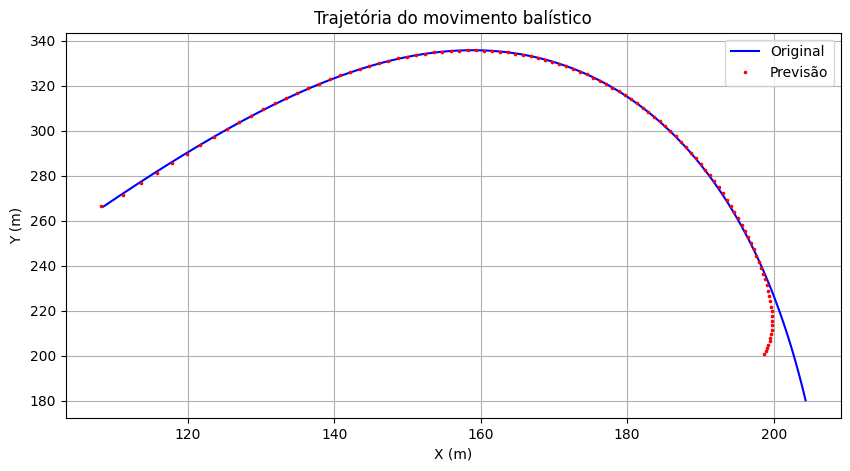

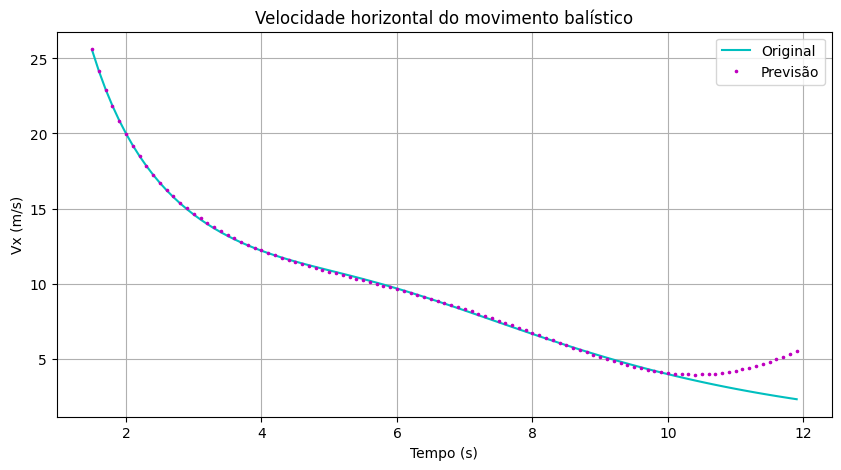

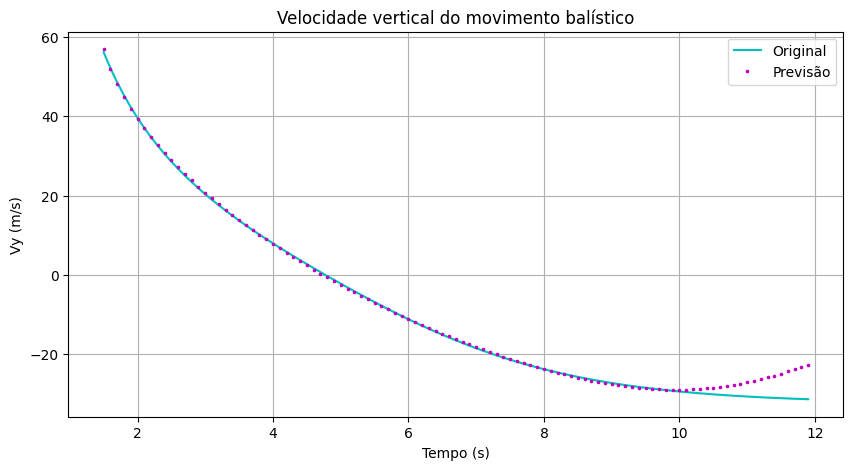

In [78]:
t_final = 12
sol2 = np.stack(makepath(angulo,velocidade,t_final+0.1,0.1)[:4],axis=1)
previsoes = ((sol2[:train_window,:]+0*np.random.normal(size=(train_window,4))-mean)/std).tolist()
sol2 = (sol2-mean)/std
for i in range(101-train_window+t_final*10-100):
    prev_temp = model_keras((np.array([previsoes[k][:] for k in range(i,train_window+i)]).reshape(-1,train_window,4)))
    previsoes.append(prev_temp.numpy().tolist()[0])
previsoes = np.array(previsoes)*std+mean
sol2 = sol2*std+mean

plt.figure(figsize=(10,5))
x = sol2[:,0]
y =  sol2[:,1]
v_x = sol2[:,2]
v_y =  sol2[:,3]
x_2 = previsoes[:,0]
y_2 = previsoes[:,1]
vx_2 = previsoes[:,2]
vy_2 = previsoes[:,3]

n = -1
m = 15

t_pontos = np.arange(0,t_final+0.1,0.1)
print(angulo,velocidade)
plt.plot(x[m:n], y[m:n], 'b-', label="Original")
plt.plot(x_2[m:n], y_2[m:n], 'ro', label="Previsão",markersize=1.6)
plt.legend()
plt.title("Trajetória do movimento balístico")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.grid(1)
plt.savefig("imagens/trajetoria_bal_unico.png")
plt.figure(figsize=(10,5))

plt.plot(t_pontos[m:n], v_x[m:n], 'c-', label="Original",markersize=1.6)
plt.plot(t_pontos[m:n], vx_2[m:n], 'mo', label="Previsão",markersize=1.6)
plt.legend()
plt.xlabel("Tempo (s)")
plt.ylabel("Vx (m/s)")
plt.title("Velocidade horizontal do movimento balístico")
plt.grid(1)
plt.savefig("imagens/horizontal_bal_unico.png")
plt.figure(figsize=(10,5))

plt.plot(t_pontos[m:n], v_y[m:n], 'c-', label="Original",markersize=1.6)
plt.plot(t_pontos[m:n], vy_2[m:n], 'mo', label="Previsão",markersize=1.6)
plt.legend()
plt.xlabel("Tempo (s)")
plt.ylabel("Vy (m/s)")
plt.title("Velocidade vertical do movimento balístico")
plt.grid(1)
plt.savefig("imagens/vertical_bal_unico.png")
